In [1]:
rm(list = ls())
setwd("/mnt/c/git_repos/iORD_hepatitis/")
require(tidyverse)
require(data.table)
require(lubridate)
require(foreach)
require(doParallel)
require(funtimes)
require(tidyquant)

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The follo

### Load data

In [2]:
df <- fread("data/IORD_ASHep-UE_34_20230120_LIMS.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           CollectionDateTime = as.Date(CollectionDateTime)) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))

age_df <- fread("data/IORD_ASHep-UE_34_20230120_Attendances.csv") %>%
    filter(AttendanceStartDate < as.Date("2023-01-01")) %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           AttendanceEndDate = as.Date(AttendanceEndDate),
           LinkedBirthmonth = as.Date(LinkedBirthmonth)) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(AttendanceMonth = as.Date(AttendanceMonth),
           AttendanceTwoMonth = as.Date(AttendanceTwoMonth)) %>%
    mutate(age_upon_presentation = time_length(AttendanceStartDate -
                                               LinkedBirthmonth, "year")) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15")) %>%
    arrange(AttendanceStartDate) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))

month_df <- df %>%
    mutate(CollectionMonth = cut(CollectionDateTime, breaks = "month")) %>%
    mutate(CollectionTwoMonths = cut(CollectionDateTime, breaks = "2 months")) %>%
    mutate(CollectionMonth = as.Date(CollectionMonth),
           CollectionTwoMonths = as.Date(CollectionTwoMonths)) %>%
    left_join(age_df) %>%
    arrange(AttendanceStartDate)

admission_df <- fread("data/IORD_ASHep-UE_34_20230120_InpatientSpells.csv") %>%
    filter(AttendanceStartDate < as.Date("2023-01-01")) %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate))
    
# First entry only
age_first <- age_df %>%
    distinct(ClusterID, .keep_all = T)
month_first <- month_df %>%
    distinct(ClusterID, .keep_all = T)

Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Warning message in left_join(., age_df):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 42 of `x` matches multiple rows in `y`.
ℹ Row 170136 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


`summarise()` has grouped output by 'AttendanceMonth'. You can override using the `.groups` argument.


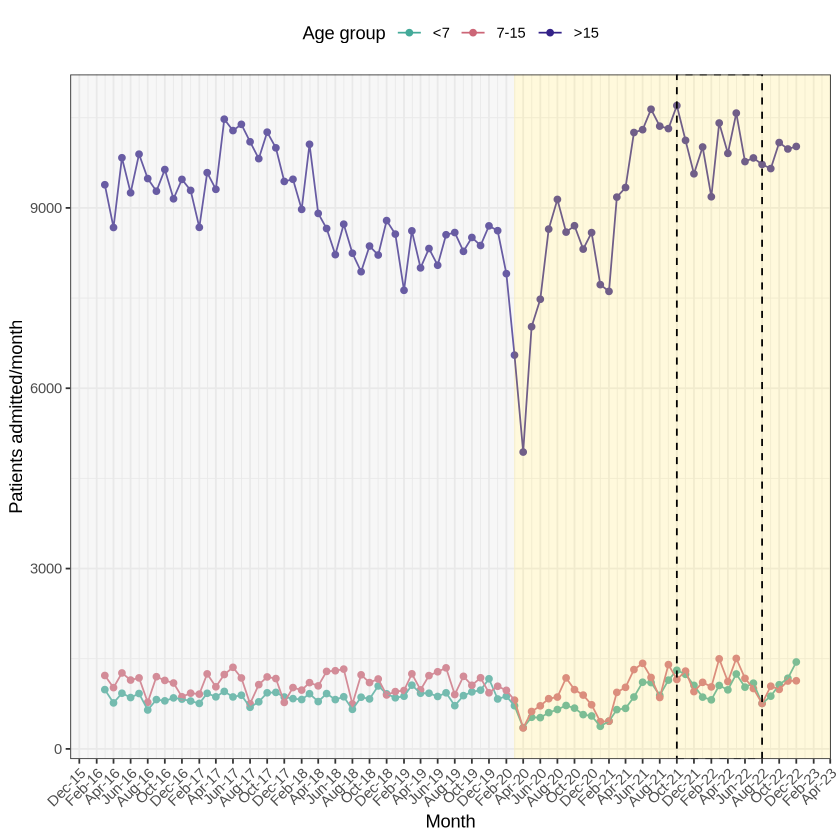

In [3]:
age_df %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15"))) %>%
    group_by(AttendanceMonth, age_group) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = AttendanceMonth, y = n, color = age_group)) +
        geom_point() +
        geom_line() +
    # Annotate epochs
    annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey90",
             alpha = 0.3) +
    annotate("rect",
             xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
             ymin = -Inf, ymax = Inf,
             fill = "lightgoldenrod1",
             alpha = 0.3) +
    annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
    # Change date scale
    scale_x_date(date_labels="%b-%y", date_breaks  = "2 month") +
    # Plot overall statistics
    scale_color_manual(values = c("#44AA99", "#CC6677", "#332288")) +
    theme_bw() + 
    labs(x = "Month", y = "Patients admitted/month", color = "Age group") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "top")

ggsave("results/admissions.pdf", dpi = 600, width = 12, height = 3)

WAVK trend test

In [4]:
admission_plot_df <-  age_df %>%
    distinct(AttendanceStartDate, ClusterID, .keep_all = T) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15"))) %>%
    group_by(AttendanceMonth, age_group) %>%
    summarise(n = n()) %>%
    mutate(is_outbreak = ifelse(AttendanceMonth <= as.Date("2022-08-31") & AttendanceMonth >= as.Date("2021-10-01"),
                        T, F))

kids <- admission_plot_df %>%
             filter(is_outbreak) %>%
             filter(age_group == "<7")
old_kids <- admission_plot_df %>%
             filter(is_outbreak) %>%
             filter(age_group == "7-15")

adults <- admission_plot_df %>%
             filter(is_outbreak) %>%
             filter(age_group == ">15")

# lm
# notrend_test(kids$n,
#              test = "WAVK", 
#              factor.length = "adaptive.selection")

# notrend_test(old_kids$n,
#              test = "WAVK", 
#              factor.length = "adaptive.selection")

# notrend_test(adults$n,
#              test = "WAVK", 
#              factor.length = "adaptive.selection")


`summarise()` has grouped output by 'AttendanceMonth'. You can override using the `.groups` argument.


In [5]:
notrend_test(kids$n,
             test = "WAVK", 
             Window = 3)

notrend_test(old_kids$n,
             test = "WAVK", 
             Window = 3)

notrend_test(adults$n,
             test = "WAVK", 
             Window = 3)



	Sieve-bootstrap WAVK trend test

data:  kids$n
WAVK test statistic = 0.78542, moving window = 3, p-value = 1
alternative hypothesis: (non-)monotonic trend.
sample estimates:
$AR_order
[1] 3

$AR_coefficients
     phi_1      phi_2      phi_3 
 0.4293007  0.3752048 -0.8552168 




	Sieve-bootstrap WAVK trend test

data:  old_kids$n
WAVK test statistic = 0.0053629, moving window = 3, p-value = 0.997
alternative hypothesis: (non-)monotonic trend.
sample estimates:
$AR_order
[1] 0

$AR_coefficients
numeric(0)




	Sieve-bootstrap WAVK trend test

data:  adults$n
WAVK test statistic = -0.44597, moving window = 3, p-value = 1
alternative hypothesis: (non-)monotonic trend.
sample estimates:
$AR_order
[1] 5

$AR_coefficients
     phi_1      phi_2      phi_3      phi_4      phi_5 
 0.2630299  0.8112878 -0.8147132 -0.2687478  0.8807255 



### No. of ALT measurements per month

In [6]:
alt_df <- month_df %>%  
  group_by(CollectionMonth, LinkedSex) %>%
  filter(TestName == "ALT") %>%
  summarise(n_alt = n()) %>%
  mutate(CollectionMonth = as.Date(CollectionMonth)) %>%
  ungroup()

wbc_df <- month_df %>%  
  group_by(CollectionMonth, LinkedSex) %>%
  filter(TestName == "WHITE CELLS") %>%
  summarise(n_wbc = n()) %>%
  mutate(CollectionMonth = as.Date(CollectionMonth)) %>%
  ungroup()

plot_df <- alt_df %>%
  inner_join(wbc_df) %>%
  mutate(alt_wbc = n_alt / n_wbc) %>%
  arrange(desc(CollectionMonth))

`summarise()` has grouped output by 'CollectionMonth'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'CollectionMonth'. You can override using the `.groups` argument.
Joining with `by = join_by(CollectionMonth, LinkedSex)`


#### ALT over time

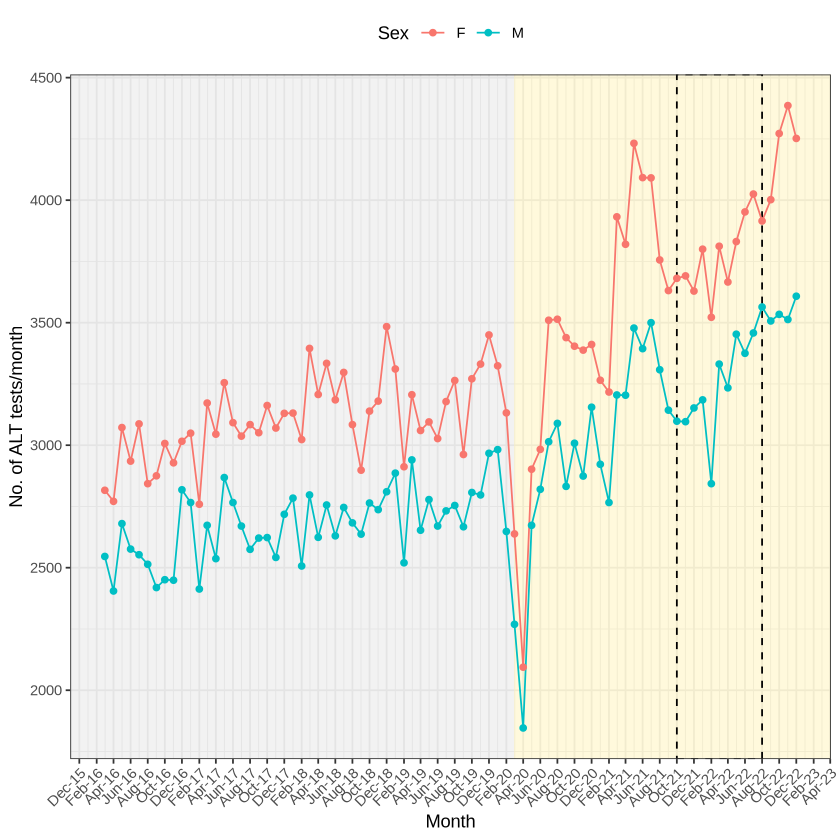

In [7]:
plot_df %>%
  filter(LinkedSex %in% c("F", "M"),
         CollectionMonth < as.Date("2023-01-01")) %>%
  ggplot(aes(x = CollectionMonth, y = n_alt, color = LinkedSex)) +
    annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey83",
             alpha = 0.3) +
    annotate("rect",
             xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
             ymin = -Inf, ymax = Inf,
             fill = "lightgoldenrod1",
             alpha = 0.3) +
    annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
    geom_line() +
    # Change date scale
    scale_x_date(date_labels="%b-%y", date_breaks  = "2 month") +
    geom_point() +
    theme_bw() +
    labs(x = "Month", 
       y = "No. of ALT tests/month",
       color = "Sex") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "top")

ggsave("results/ALT_tests_per_month.pdf", width = 12, height = 3, dpi = 600)

#### ALT to WBC ratio over time

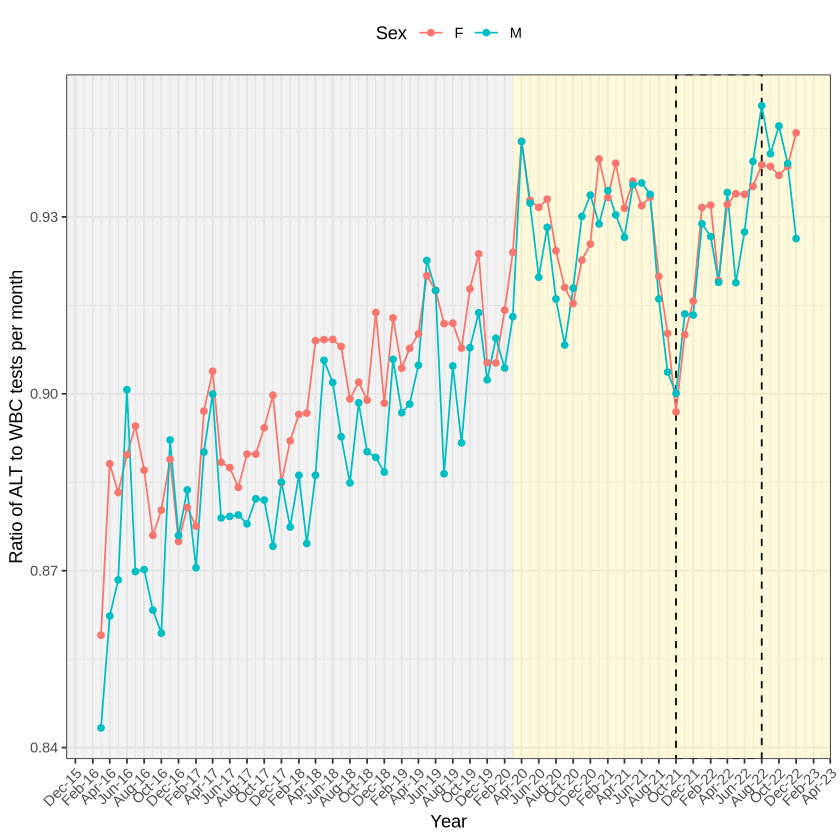

In [8]:
plot_df %>%
    filter(LinkedSex %in% c("F", "M"),
           CollectionMonth < "2023-01-01") %>%
    ggplot(aes(x = CollectionMonth, y = alt_wbc, color = LinkedSex)) +
    annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey83",
             alpha = 0.3) +
    annotate("rect",
             xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
             ymin = -Inf, ymax = Inf,
             fill = "lightgoldenrod1",
             alpha = 0.3) +
    annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
    geom_line() +
    geom_point() +
    # Change date scale
    scale_x_date(date_labels="%b-%y", date_breaks  = "2 month") +
    theme_bw() +
    labs(x = "Year", 
         y = "Ratio of ALT to WBC tests per month",
         color = "Sex") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "top")

ggsave("results/ALT_tests_to_WBC_per_month.pdf", width = 12, height = 3, dpi = 600)

#### Testing for positive trend in all ALT measurements
Using local regression-based WAVK test (Wang, Akritas, and Van Keilegom 2008)

In [9]:
alt_df <- month_df %>%  
  group_by(CollectionMonth) %>%
  filter(TestName == "ALT") %>%
  summarise(n_alt = n()) %>%
  mutate(CollectionMonth = as.Date(CollectionMonth)) %>%
  ungroup()

wbc_df <- month_df %>%  
  group_by(CollectionMonth) %>%
  filter(TestName == "WHITE CELLS") %>%
  summarise(n_wbc = n()) %>%
  mutate(CollectionMonth = as.Date(CollectionMonth)) %>%
  ungroup()

plot_df <- alt_df %>%
    inner_join(wbc_df) %>%
    mutate(alt_wbc = n_alt / n_wbc) %>%
    arrange(desc(CollectionMonth)) %>%
    arrange(CollectionMonth)

notrend_test(plot_df$n_alt, test = "WAVK", factor.length = "adaptive.selection")
notrend_test(plot_df$alt_wbc, test = "WAVK", factor.length = "adaptive.selection")

Joining with `by = join_by(CollectionMonth)`



	Sieve-bootstrap WAVK trend test

data:  plot_df$n_alt
WAVK test statistic = 13.436, moving window = 6, p-value < 2.2e-16
alternative hypothesis: (non-)monotonic trend.
sample estimates:
$AR_order
[1] 0

$AR_coefficients
numeric(0)




	Sieve-bootstrap WAVK trend test

data:  plot_df$alt_wbc
WAVK test statistic = 91.127, moving window = 6, p-value < 2.2e-16
alternative hypothesis: (non-)monotonic trend.
sample estimates:
$AR_order
[1] 2

$AR_coefficients
     phi_1      phi_2 
0.42100923 0.09558134 



### Median/IQRs of ALT levels

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = as.numeric(Value)`.
Caused by warning:
! NAs introduced by coercion”
`summarise()` has grouped output by 'CollectionMonth'. You can override using the `.groups` argument.


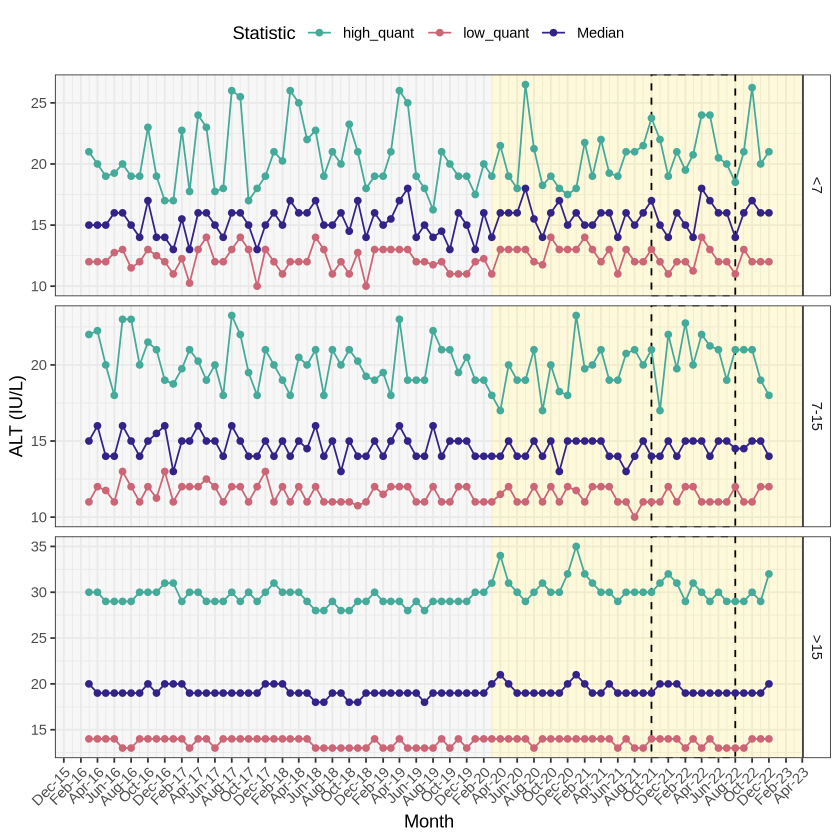

In [10]:
ALT <- month_df %>% 
    distinct(ClusterID, AttendanceStartDate, TestName, .keep_all = T) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15"),
           Value = as.numeric(Value)) %>%
    filter(!is.na(Value)) %>%
    filter(TestName == "ALT") %>%
    group_by(CollectionMonth, age_group) %>%
    summarise(low_quant = quantile(Value, c(0.25)),
              high_quant = quantile(Value, c(0.75)),
              Median = median(Value)) %>%
    mutate(CollectionMonth = as.Date(CollectionMonth)) %>%
    pivot_longer(!c(CollectionMonth, age_group), names_to = "statistic", values_to = "value")

ALT %>%
    filter(CollectionMonth < as.Date("2023-01-01")) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15"))) %>%
    ggplot(aes(x = CollectionMonth, y = value, color = statistic)) +
    # Annotate epochs
    annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey90",
             alpha = 0.3) +
    annotate("rect",
             xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
             ymin = -Inf, ymax = Inf,
             fill = "lightgoldenrod1",
             alpha = 0.3) +
    annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
    # Plot trends
    geom_point() +
    geom_line() +
    # Change date scale
    scale_x_date(date_labels="%b-%y", date_breaks  = "2 month") +
    # Plot overall statistics
    scale_color_manual(values = c("#44AA99", "#CC6677", "#332288")) +
    facet_grid(age_group ~ ., scales = "free") +
    theme_bw() + 
    labs(x = "Month", y = "ALT (IU/L)", color = "Statistic") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
         legend.position = "top",
         strip.background = element_rect(fill = "white"))

ggsave("results/ALT_levels.pdf", dpi = 600, width = 12, height = 4)

In [11]:
# notrend_test(ALT$value, test = "WAVK", factor.length = "adaptive.selection")
notrend_test((ALT %>% filter(age_group == "<7"))$value, test = "WAVK", factor.length = "adaptive.selection")
notrend_test((ALT %>% filter(age_group == "7-15"))$value, test = "WAVK", factor.length = "adaptive.selection")
notrend_test((ALT %>% filter(age_group == ">15"))$value, test = "WAVK", factor.length = "adaptive.selection")


	Sieve-bootstrap WAVK trend test

data:  (ALT %>% filter(age_group == "<7"))$value
WAVK test statistic = -1.7074, moving window = 13, p-value = 0.487
alternative hypothesis: (non-)monotonic trend.
sample estimates:
$AR_order
[1] 7

$AR_coefficients
      phi_1       phi_2       phi_3       phi_4       phi_5       phi_6 
 0.14953635 -0.08355859  0.47146626 -0.19330117 -0.19391861  0.20187347 
      phi_7 
-0.22048093 




	Sieve-bootstrap WAVK trend test

data:  (ALT %>% filter(age_group == "7-15"))$value
WAVK test statistic = -2.1286, moving window = 14, p-value = 0.486
alternative hypothesis: (non-)monotonic trend.
sample estimates:
$AR_order
[1] 7

$AR_coefficients
     phi_1      phi_2      phi_3      phi_4      phi_5      phi_6      phi_7 
 0.1355708 -0.1100726  0.3067900 -0.2538556 -0.1940873  0.3671298 -0.1870456 




	Sieve-bootstrap WAVK trend test

data:  (ALT %>% filter(age_group == ">15"))$value
WAVK test statistic = -2.1389, moving window = 14, p-value = 0.319
alternative hypothesis: (non-)monotonic trend.
sample estimates:
$AR_order
[1] 6

$AR_coefficients
     phi_1      phi_2      phi_3      phi_4      phi_5      phi_6 
 0.1151258  0.2725969  0.6045583 -0.2404528 -0.3944274  0.2691035 



In [12]:
# ALT
month_df %>% 
    distinct(ClusterID, AttendanceStartDate, TestName, .keep_all = T) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15"),
           Value = as.numeric(Value)) %>%
    filter(!is.na(Value)) %>%
    filter(TestName == "ALT") %>%
    mutate(epoch = ifelse(AttendanceStartDate < as.Date("2020-03-11"), 
                          "Pre-COVID", 
                          "COVID")) %>%
    mutate(epoch = ifelse(AttendanceStartDate >= as.Date("2021-10-01") &
                            AttendanceStartDate <= as.Date("2022-08-31"),
                          "AS-Hep-UA", epoch)) %>%
    group_by(epoch, age_group) %>%
    summarise(median_ALT = median(Value),
              ALT_low = quantile(Value, c(0.25)),
              ALT_high = quantile(Value, c(0.75)))

# AST
month_df %>% 
    distinct(ClusterID, AttendanceStartDate, TestName, .keep_all = T) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15"),
           Value = as.numeric(Value)) %>%
    filter(!is.na(Value)) %>%
    filter(TestName == "AST") %>%
    mutate(epoch = ifelse(AttendanceStartDate < as.Date("2020-03-11"), 
                          "Pre-COVID", 
                          "COVID")) %>%
    mutate(epoch = ifelse(AttendanceStartDate >= as.Date("2021-10-01") &
                            AttendanceStartDate <= as.Date("2022-08-31"),
                          "AS-Hep-UA", epoch)) %>%
    group_by(epoch, age_group) %>%
    summarise(median_AST = median(Value),
              AST_low = quantile(Value, c(0.25)),
              AST_high = quantile(Value, c(0.75)))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = as.numeric(Value)`.
Caused by warning:
! NAs introduced by coercion”
`summarise()` has grouped output by 'epoch'. You can override using the `.groups` argument.


epoch,age_group,median_ALT,ALT_low,ALT_high
<chr>,<chr>,<dbl>,<dbl>,<dbl>
AS-Hep-UA,7-15,15,11,20
AS-Hep-UA,<7,15,12,21
AS-Hep-UA,>15,19,14,30
COVID,7-15,14,11,20
COVID,<7,16,12,21
COVID,>15,19,14,31
Pre-COVID,7-15,15,12,20
Pre-COVID,<7,15,12,20
Pre-COVID,>15,19,14,29


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = as.numeric(Value)`.
Caused by warning:
! NAs introduced by coercion”
`summarise()` has grouped output by 'epoch'. You can override using the `.groups` argument.


epoch,age_group,median_AST,AST_low,AST_high
<chr>,<chr>,<dbl>,<dbl>,<dbl>
AS-Hep-UA,7-15,36.0,24.00,101.00
AS-Hep-UA,<7,40.0,31.00,140.50
AS-Hep-UA,>15,39.5,22.00,109.75
COVID,7-15,32.0,20.50,217.00
COVID,<7,38.0,29.75,118.25
COVID,>15,45.0,23.00,118.00
Pre-COVID,7-15,34.0,21.00,119.00
Pre-COVID,<7,56.0,33.00,222.50
Pre-COVID,>15,42.0,22.00,109.00


### Extended case definitions

In [13]:
month_df %>% 
    distinct(ClusterID, AttendanceStartDate, TestName, .keep_all = T) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15"),
           Value = as.numeric(Value),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    filter(!is.na(Value)) %>%
    filter(TestName == "ALT") %>%
    filter(Value > 500) %>%
    group_by(age_group, is_outbreak) %>%
    summarise(n = n_distinct(ClusterID, AttendanceStartDate))


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = as.numeric(Value)`.
Caused by warning:
! NAs introduced by coercion”
`summarise()` has grouped output by 'age_group'. You can override using the `.groups` argument.


age_group,is_outbreak,n
<chr>,<lgl>,<int>
7-15,FALSE,28
7-15,TRUE,3
<7,FALSE,14
<7,TRUE,1
>15,FALSE,1673
>15,TRUE,275


In [14]:
month_df %>% 
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(Value = as.numeric(Value)) %>%
    filter(!is.na(Value)) %>%
    filter(TestName == "ALT") %>%
    group_by(CollectionMonth, age_group) %>%
    summarise(n = n()) %>%
    group_by(age_group) %>%
    summarise(median = median(n))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = as.numeric(Value)`.
Caused by warning:
! NAs introduced by coercion”
`summarise()` has grouped output by 'CollectionMonth'. You can override using the `.groups` argument.


age_group,median
<chr>,<dbl>
7-15,9
<7,5
>15,427


### Temporal distribution of ALT level classifications

In [15]:
month_df %>% 
    filter(TestName == "ALT",
           LinkedSex %in% c("M", "F")) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T)

ClusterID,AttendanceStartDate,CollectionID,CollectionDateTime,ReceiveDateTime,SetName,TestName,RefRange,Units,Value,⋯,EthnicGroupCode,LinkedSex,LinkedBirthmonth,LinkedDeathdate,SpineCheckDate,LinkageWarningFlag,AttendanceMonth,AttendanceTwoMonth,age_upon_presentation,age_group
<int>,<date>,<chr>,<date>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<date>,<chr>,<chr>,<int>,<date>,<date>,<dbl>,<chr>
148149,2016-03-01,N6908273,2016-03-01,2016-03-01 04:06:00,A2,ALT,10-45,IU/L,17,⋯,C,F,1987-07-01,NULL,2023-01-14 17:00:07.630,0,2016-03-01,2016-03-01,28,>15
275893,2016-03-01,N6901363,2016-03-01,2016-03-01 10:57:00,A2,ALT,10-45,IU/L,20,⋯,A,F,1974-06-01,NULL,2023-01-07 17:00:09.063,0,2016-03-01,2016-03-01,41,>15
1088702,2016-03-01,N6899001,2016-03-01,2016-03-01 20:59:00,A2,ALT,10-45,IU/L,10,⋯,K,F,1940-08-01,NULL,2023-01-17 17:00:09.563,0,2016-03-01,2016-03-01,75,>15
2077289,2016-03-01,N6918463,2016-03-01,2016-03-01 13:04:00,A2,ALT,10-45,IU/L,1967,⋯,A,M,1946-03-01,NULL,2023-01-11 14:00:09.793,0,2016-03-01,2016-03-01,70,>15
2259169,2016-03-01,N6889499,2016-03-01,2016-03-01 10:46:00,A2,ALT,10-45,IU/L,31,⋯,Z,M,1957-09-01,NULL,2023-01-15 17:00:09.070,0,2016-03-01,2016-03-01,58,>15
3404193,2016-03-01,N6918377,2016-03-01,2016-03-01 17:56:00,A2,ALT,10-45,IU/L,8,⋯,A,F,1922-09-01,2019-02-06 00:00:00.000,2021-12-11 14:00:06.420,0,2016-03-01,2016-03-01,93,>15
3404480,2016-03-01,N6912419,2016-03-01,2016-03-01 22:53:00,A2,ALT,10-45,IU/L,15,⋯,B,M,1943-02-01,NULL,2023-01-11 14:00:09.793,0,2016-03-01,2016-03-01,73,>15
5628208,2016-03-01,N6889533,2016-03-01,2016-03-01 17:09:00,A2,ALT,10-45,IU/L,20,⋯,A,M,1982-09-01,NULL,2023-01-08 17:00:08.560,0,2016-03-01,2016-03-01,33,>15
9289219,2016-03-01,N6886448,2016-03-01,2016-03-01 16:35:00,A2,ALT,10-45,IU/L,19,⋯,Z,F,1993-06-01,NULL,2023-01-11 14:00:09.793,0,2016-03-01,2016-03-01,22,>15


In [16]:
month_df %>% summarise(max(AttendanceMonth),
                      min(AttendanceMonth))

max(AttendanceMonth),min(AttendanceMonth)
<date>,<date>
2022-12-01,2016-03-01


In [17]:
class_count_df <- month_df %>% 
    filter(TestName == "ALT",
           LinkedSex %in% c("M", "F")) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    mutate(Value = as.numeric(Value)) %>%
    mutate(Value = ifelse(is.na(Value), 0, Value)) %>%
    mutate(ALT_class = case_when(Value <= 45 ~ "Normal (<1x ULN)",
                                 Value > 45 & Value <= 90 ~ "Mild (1-2x IU/L)",
                                 Value > 90 & Value <= 500  ~ "Moderate (2-5x ULN)",
                                 Value > 500 ~ ">500 IU/L")) %>%
    mutate(ALT_class = factor(ALT_class, c("Normal (<1x ULN)", 
                                           "Mild (1-2x IU/L)", 
                                           "Moderate (2-5x ULN)",
                                           ">500 IU/L")),
          age_group = factor(age_group, c("<7", "7-15", ">15"))) %>%
    group_by(CollectionMonth, age_group, ALT_class, .drop = F) %>%
    summarise(n = n()) %>%
    mutate(prop = n / sum(n)) %>%
    mutate(CollectionMonth = as.Date(CollectionMonth)) %>%
    filter(CollectionMonth < as.Date("2023-01-01")) %>%
    ungroup()

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = as.numeric(Value)`.
Caused by warning:
! NAs introduced by coercion”
`summarise()` has grouped output by 'CollectionMonth', 'age_group'. You can override using the `.groups` argument.


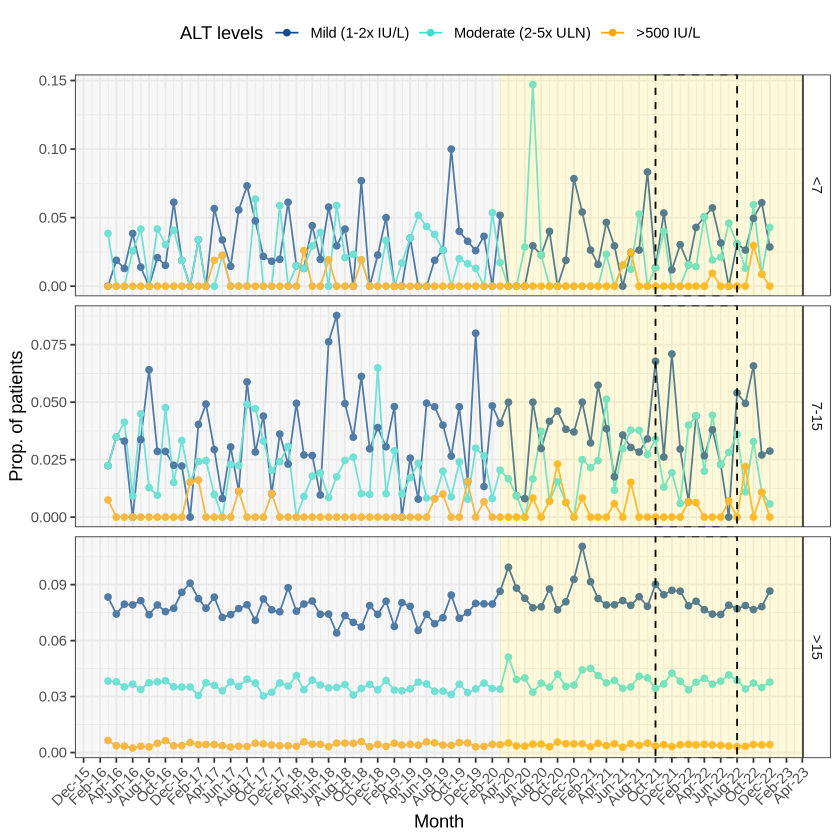

In [18]:
total_counts <- class_count_df %>%
    group_by(CollectionMonth) %>%
    summarise(total = sum(n))

class_count_df %>%
    filter(ALT_class != "Normal (<1x ULN)",
           !is.na(ALT_class)) %>%
    ggplot(aes(x = CollectionMonth, y = prop, color = ALT_class)) +
        geom_line() +
        geom_point() +
        scale_color_manual(values = c("dodgerblue4", "turquoise", "orange", "red", "black")) +
        scale_x_date(date_labels="%b-%y", date_breaks  = "2 month") +
        # Simple moving average
#         geom_ma(ma_fun = SMA, n = 6) +
        facet_grid(rows = vars(age_group), 
#                    cols = vars(ALT_class), 
                   scales = "free") +
        theme_bw() +
            annotate("rect",
                     xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
                     ymin = -Inf, ymax = Inf,
                     fill = "grey90",
                     alpha = 0.3) +
            annotate("rect",
                     xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                     ymin = -Inf, ymax = Inf,
                     fill = "lightgoldenrod1",
                     alpha = 0.3) +
            annotate("rect",
                     xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
                     ymin = -Inf, ymax = Inf,
                     fill = NA,
                     color = "black",
                     lty = "dashed",
                     alpha = 0.3) +
        labs(x = "Month", y = "Prop. of patients",
              color = "ALT levels") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1),
             legend.position = "top",
             strip.background = element_rect(fill = "white"))

ggsave("results/ALT_classifications.pdf", width = 12, height = 4, dpi = 600)

In [19]:
notrend_test((class_count_df %>% filter(age_group == "<7"))$prop, test = "WAVK", factor.length = "adaptive.selection")
notrend_test((class_count_df %>% filter(age_group == "7-15"))$prop, test = "WAVK", factor.length = "adaptive.selection")
notrend_test((class_count_df %>% filter(age_group == ">15"))$prop, test = "WAVK", factor.length = "adaptive.selection")


	Sieve-bootstrap WAVK trend test

data:  (class_count_df %>% filter(age_group == "<7"))$prop
WAVK test statistic = -2.579, moving window = 18, p-value = 0.465
alternative hypothesis: (non-)monotonic trend.
sample estimates:
$AR_order
[1] 4

$AR_coefficients
       phi_1        phi_2        phi_3        phi_4 
-0.004071203 -0.009811454 -0.015658016  0.987488668 




	Sieve-bootstrap WAVK trend test

data:  (class_count_df %>% filter(age_group == "7-15"))$prop
WAVK test statistic = -2.579, moving window = 18, p-value = 0.507
alternative hypothesis: (non-)monotonic trend.
sample estimates:
$AR_order
[1] 4

$AR_coefficients
        phi_1         phi_2         phi_3         phi_4 
 0.0005995358 -0.0054361609 -0.0115229578  0.9930997629 




	Sieve-bootstrap WAVK trend test

data:  (class_count_df %>% filter(age_group == ">15"))$prop
WAVK test statistic = -2.5975, moving window = 18, p-value = 0.582
alternative hypothesis: (non-)monotonic trend.
sample estimates:
$AR_order
[1] 4

$AR_coefficients
        phi_1         phi_2         phi_3         phi_4 
 0.0069239456 -0.0002195443 -0.0073626029  0.9997188204 



In [20]:
class_count_df %>%
    group_by(age_group) %>%
    summarise(median = median(n))

age_group,median
<fct>,<dbl>
<7,1
7-15,3
>15,313


In [21]:
# class_count_df2 <- two_month_df %>% 
#     filter(TestName == "ALT",
#            LinkedSex %in% c("M", "F")) %>%
#     mutate(AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
#     left_join(age_df) %>%
#     arrange(AttendanceStartDate) %>%
#     distinct(ClusterID, .keep_all = T) %>%
#     mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
#     mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
#                                  age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
#                                  age_upon_presentation >= 16 ~ ">15"),
#            Value = as.numeric(Value)) %>%
#     # Replace <6, <30 with 0.0001 to prevent divide by zero error
#     mutate(Value = ifelse(is.na(Value), 0.0001, Value)) %>%
#     # Define ULN values
#     mutate(ULN = ifelse(LinkedSex == "M", 50, 30)) %>%
#     # Get fold difference
#     mutate(ALT_fold = Value / ULN) %>%
#     mutate(ALT_class = ifelse(ALT_fold <= 1, "<=ULN", ">ULN")) %>%
#     group_by(CollectionMonth, age_group, ALT_class) %>%
#     summarise(n = n()) %>%
#     mutate(prop = n / sum(n)) %>%
#     mutate(CollectionMonth = as.Date(CollectionMonth)) %>%
#     ungroup()
    
# class_count_df2 %>%
#     mutate(ALT_class = factor(ALT_class, c("<=ULN", ">ULN"))) %>%
#     filter(ALT_class == ">ULN") %>%
#     ggplot(aes(x = CollectionMonth, y = prop, color = age_group)) +
#         geom_line() +
#         geom_point() +
#         scale_color_manual(values = c("seagreen", "olivedrab3", "orange", "red", "black")) +
# #     facet_grid(rows = "age_group", scales = "free") +
#     theme_bw() +
#         annotate("rect",
#                  xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
#                  ymin = -Inf, ymax = Inf,
#                  fill = "grey90",
#                  alpha = 0.3) +
#         theme_bw() +
#         annotate("rect",
#                  xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
#                  ymin = -Inf, ymax = Inf,
#                  fill = "lightgoldenrod1",
#                  alpha = 0.3) +
#         annotate("rect",
#                  xmin = as.Date("2021-10-01"), xmax = as.Date("2022-05-01"), 
#                  ymin = -Inf, ymax = Inf,
#                  fill = NA,
#                  color = "black",
#                  lty = "dashed",
#                  alpha = 0.3)